## Import Libraries

In [3]:
import os
import torch
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
from torchvision import datasets, transforms, models
from collections import Counter
from torchvision.transforms import Resize, CenterCrop, ToTensor, Normalize, GaussianBlur, Grayscale
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, Dataset

import cv2 
from PIL import Image, ImageFilter, ImageOps
from torchvision.transforms.functional import to_pil_image
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.optim import lr_scheduler

from tkinter import filedialog, Tk

# from gradcam import GradCAM, GradCAMpp
# from gradcam.utils import visualize_cam

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

import dill
import torch.multiprocessing as mp

# from captum.attr import IntegratedGradients
# from captum.attr import visualization as viz

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # as M1 Mac Does not have a dedicated GPU

##### Specify the path to the locally saved dataset

In [5]:
train_data_dir = '/Users/tharanidissanayake/downloads/2nd_Dataset'
original_dataset = datasets.ImageFolder(train_data_dir)

In [6]:
class ContrastStretching:
    def __call__(self, img):
        # Convert PIL Image to NumPy array
        img_np = np.array(img)
        
        # Check if the image is grayscale or RGB
        if img_np.ndim == 2:  # Grayscale image
            img_np = self.apply_contrast_stretching(img_np)
        elif img_np.ndim == 3:  # RGB image
            # Apply contrast stretching to each channel individually
            for i in range(img_np.shape[-1]):
                img_np[:, :, i] = self.apply_contrast_stretching(img_np[:, :, i])
        
        # Convert back to PIL Image
        return Image.fromarray(img_np.astype('uint8'))
    
    def apply_contrast_stretching(self, channel):
        in_min, in_max = np.percentile(channel, (0, 100))
        out_min, out_max = 0, 255
        channel = np.clip((channel - in_min) * (out_max - out_min) / (in_max - in_min) + out_min, out_min, out_max)
        return channel

class UnsharpMask:
    def __init__(self, radius=1, percent=100, threshold=3):
        self.radius = radius
        self.percent = percent
        self.threshold = threshold

    def __call__(self, img):
        return img.filter(ImageFilter.UnsharpMask(radius=self.radius, 
                                                  percent=self.percent, 
                                                  threshold=self.threshold
                                                 ))

class GaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0)):
        self.kernel_size = kernel_size
        self.sigma = sigma

    def __call__(self, img):
        sigma = np.random.uniform(self.sigma[0], self.sigma[1])
        img = img.filter(ImageFilter.GaussianBlur(sigma))
        return img

#### Preprocess the dataset

In [7]:
preprocess_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: transforms.functional.rotate(img, 90)),
    ContrastStretching(),
    UnsharpMask(radius=1, percent=100, threshold=3),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
])

preprocessed_dataset = datasets.ImageFolder(root=train_data_dir, transform=preprocess_transform)

data_loader = DataLoader(preprocessed_dataset, batch_size=32, shuffle=True)

In [8]:
def calculate_psnr_ssim(original_dataset, preprocessed_dataset, num_samples=100, resize=(224, 224)):
    psnr_values = []
    ssim_values = []

    for i in range(num_samples):
        original_img = original_dataset[i][0] # original MRI
        preprocessed_img = preprocessed_dataset[i][0] # preprocessed MRI

        if not isinstance(original_img, Image.Image):
            original_img = to_pil_image(original_img)
        if not isinstance(preprocessed_img, Image.Image):
            preprocessed_img = to_pil_image(preprocessed_img)

        # Convert MRI to grayscale
        original_img = original_img.convert("L")
        preprocessed_img = preprocessed_img.convert("L")

        # Resize images
        original_img = original_img.resize(resize)
        preprocessed_img = preprocessed_img.resize(resize)

        # Convert images to numpy arrays
        original_img_np = np.array(original_img)
        preprocessed_img_np = np.array(preprocessed_img)

        # Calculate PSNR and SSIM
        psnr = peak_signal_noise_ratio(original_img_np, preprocessed_img_np, data_range=original_img_np.max() - original_img_np.min())
        ssim = structural_similarity(original_img_np, preprocessed_img_np)

        psnr_values.append(psnr)
        ssim_values.append(ssim)

    # Compute average PSNR and SSIM
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    return avg_psnr, avg_ssim

# Example usage
avg_psnr, avg_ssim = calculate_psnr_ssim(original_dataset, preprocessed_dataset)
print(f"Average PSNR: {avg_psnr}, Average SSIM: {avg_ssim}")

Average PSNR: 13.132974775602571, Average SSIM: 0.1891984305217773


preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),  
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.Lambda(lambda x: x.filter(ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3))),
    transforms.ToTensor()
)

Average PSNR: 9.729432125669954, Average SSIM: 0.2833625979364462
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.ToTensor()
)

Average PSNR: 10.2026194786185, Average SSIM: 0.32374658927511385
____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)), 
    transforms.ToTensor(),
)

Average PSNR: 34.479706650199184, Average SSIM: 0.9638484917028203

____________________________________________________________________

preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 1.0)), 
    transforms.ToTensor(),
)

Average PSNR: 40.03000513450271, Average SSIM: 0.9923509776637894

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=2, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 28.919164968402907, Average SSIM: 0.9646276430637585

____________________________________________________________________
preprocess_transform = transforms.Compose(

    transforms.Resize((224, 224)),
    ContrastStretching(),
    transforms.Lambda(lambda img: img.filter(ImageFilter.UnsharpMask(radius=1, percent=100, threshold=3))),
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 0.5)), 
    transforms.ToTensor()
)

Average PSNR: 27.194490517269728, Average SSIM: 0.8948121010151182

#### MRI scan counts in each class of the dataset

In [9]:
MildDemented = '/Users/tharanidissanayake/downloads/2nd_Dataset/MildDemented'
ModerateDemented = '/Users/tharanidissanayake/downloads/2nd_Dataset/ModerateDemented'
NonDemented = '/Users/tharanidissanayake/downloads/2nd_Dataset/NonDemented'
VeryMildDemented = '/Users/tharanidissanayake/downloads/2nd_Dataset/VeryMildDemented'

count_MildDemented = len(os.listdir(MildDemented))
count_ModerateDemented = len(os.listdir(ModerateDemented))
count_NonDemented = len(os.listdir(NonDemented))
count_VeryMildDemented = len(os.listdir(VeryMildDemented))

print(f"Number of images in MildDemented: {count_MildDemented}")
print(f"Number of images in ModerateDemented: {count_ModerateDemented}")
print(f"Number of images in NonDemented: {count_NonDemented}")
print(f"Number of images in VeryMildDemented: {count_VeryMildDemented}")

print(f"\nTotal MRIs in the dataset = {count_MildDemented+count_ModerateDemented+count_NonDemented+count_VeryMildDemented}" )

Number of images in MildDemented: 5002
Number of images in ModerateDemented: 488
Number of images in NonDemented: 5010
Number of images in VeryMildDemented: 5000

Total MRIs in the dataset = 15500


#### Sample MRI before and after preprocessing

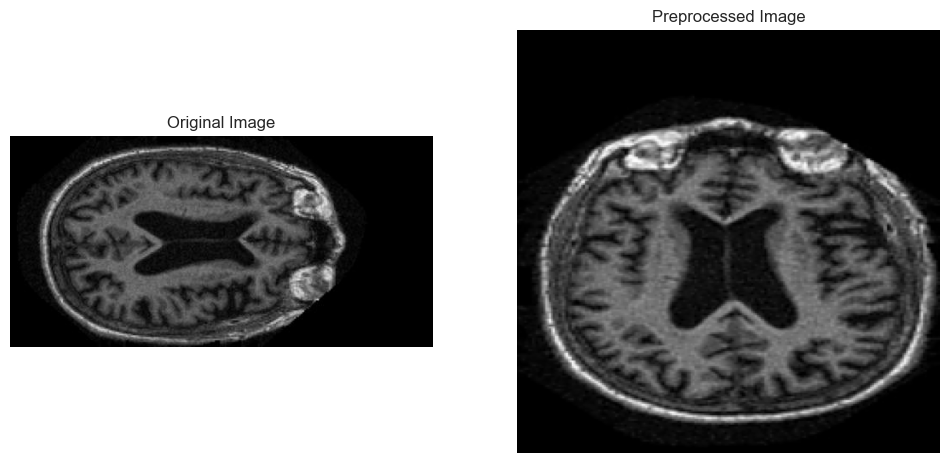

In [10]:
sample_image_path = os.path.join(MildDemented, os.listdir(MildDemented)[0])

original_image = Image.open(sample_image_path)

# Apply the preprocessing transforms
preprocessed_image = preprocess_transform(original_image)

preprocessed_image = transforms.ToPILImage()(preprocessed_image)

# Display the images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(preprocessed_image)
plt.title("Preprocessed Image")
plt.axis('off')

plt.show()

### Dataset splitting & creating DataLoaders

In [11]:
train_size = int(0.70 * len(preprocessed_dataset))
val_size = int(0.15 * len(preprocessed_dataset))
test_size = len(preprocessed_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(preprocessed_dataset, [train_size, val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

In [12]:
all_labels = [label for _, label in train_dataset]
class_distribution = Counter(all_labels)
print(class_distribution)

Counter({2: 3507, 0: 3496, 3: 3489, 1: 358})


## Building CNN

In [13]:
class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 384, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(384)

        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)

        self.fc1 = nn.Linear(384 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.output = nn.Linear(1024, num_classes)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.01))
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.01)
        x = F.leaky_relu(self.bn4(self.conv4(x)), negative_slope=0.01)
        x = self.pool(F.leaky_relu(self.bn5(self.conv5(x)), negative_slope=0.01))
        x = F.leaky_relu(self.bn6(self.conv6(x)), negative_slope=0.01)

        x = x.view(x.size(0), -1)

        x = self.dropout(F.leaky_relu(self.fc1(x), negative_slope=0.01))
        x = self.dropout(F.leaky_relu(self.fc2(x), negative_slope=0.01))
        
        x = self.output(x)

        return x

model1 = CNN1(num_classes=4)

print(model1)
summary(model1, (3,224,224))

CNN1(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_run

### Train the CNN model

Epoch 1 [train] Progress: 100%|██████████| 1357/1357 [15:10<00:00,  1.49batch/s]   


train Loss: 0.4764 Acc: 0.8094


Epoch 1 [val] Progress: 100%|██████████| 291/291 [00:25<00:00, 11.59batch/s]


val Loss: 0.1087 Acc: 0.9613


Epoch 2 [train] Progress: 100%|██████████| 1357/1357 [07:14<00:00,  3.12batch/s]


train Loss: 0.1003 Acc: 0.9678


Epoch 2 [val] Progress: 100%|██████████| 291/291 [00:29<00:00,  9.85batch/s]


val Loss: 0.0184 Acc: 0.9940


Epoch 3 [train] Progress: 100%|██████████| 1357/1357 [07:55<00:00,  2.85batch/s]


train Loss: 0.0702 Acc: 0.9805


Epoch 3 [val] Progress: 100%|██████████| 291/291 [00:30<00:00,  9.46batch/s]


val Loss: 0.2484 Acc: 0.9518


Epoch 4 [train] Progress: 100%|██████████| 1357/1357 [07:26<00:00,  3.04batch/s]


train Loss: 0.0427 Acc: 0.9881


Epoch 4 [val] Progress: 100%|██████████| 291/291 [00:31<00:00,  9.11batch/s]


val Loss: 0.0250 Acc: 0.9935


Epoch 5 [train] Progress: 100%|██████████| 1357/1357 [08:07<00:00,  2.78batch/s]


train Loss: 0.0706 Acc: 0.9817


Epoch 5 [val] Progress: 100%|██████████| 291/291 [00:31<00:00,  9.25batch/s]


val Loss: 0.0077 Acc: 0.9970


Epoch 6 [train] Progress: 100%|██████████| 1357/1357 [07:24<00:00,  3.05batch/s]


train Loss: 0.0346 Acc: 0.9905


Epoch 6 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.21batch/s]


val Loss: 0.0083 Acc: 0.9991


Epoch 7 [train] Progress: 100%|██████████| 1357/1357 [07:42<00:00,  2.93batch/s]


train Loss: 0.0405 Acc: 0.9886


Epoch 7 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.29batch/s]


val Loss: 0.0146 Acc: 0.9966


Epoch 8 [train] Progress: 100%|██████████| 1357/1357 [07:17<00:00,  3.10batch/s]


train Loss: 0.0248 Acc: 0.9939


Epoch 8 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.65batch/s]


val Loss: 0.0278 Acc: 0.9892


Epoch 9 [train] Progress: 100%|██████████| 1357/1357 [07:02<00:00,  3.21batch/s]


train Loss: 0.0371 Acc: 0.9908


Epoch 9 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.64batch/s]


val Loss: 0.0010 Acc: 0.9996


Epoch 10 [train] Progress: 100%|██████████| 1357/1357 [07:01<00:00,  3.22batch/s]


train Loss: 0.0211 Acc: 0.9945


Epoch 10 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.55batch/s]


val Loss: 0.0233 Acc: 0.9940


Epoch 11 [train] Progress: 100%|██████████| 1357/1357 [07:02<00:00,  3.21batch/s]


train Loss: 0.0372 Acc: 0.9917


Epoch 11 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.63batch/s]


val Loss: 0.0221 Acc: 0.9935


Epoch 12 [train] Progress: 100%|██████████| 1357/1357 [07:01<00:00,  3.22batch/s]


train Loss: 0.0275 Acc: 0.9931


Epoch 12 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.55batch/s]


val Loss: 0.0017 Acc: 0.9996


Epoch 13 [train] Progress: 100%|██████████| 1357/1357 [07:04<00:00,  3.20batch/s]


train Loss: 0.0239 Acc: 0.9935


Epoch 13 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.41batch/s]


val Loss: 0.0009 Acc: 0.9996


Epoch 14 [train] Progress: 100%|██████████| 1357/1357 [07:10<00:00,  3.15batch/s]


train Loss: 0.0011 Acc: 0.9997


Epoch 14 [val] Progress: 100%|██████████| 291/291 [00:26<00:00, 10.83batch/s]


val Loss: 0.0002 Acc: 1.0000


Epoch 15 [train] Progress: 100%|██████████| 1357/1357 [07:18<00:00,  3.10batch/s]


train Loss: 0.0276 Acc: 0.9939


Epoch 15 [val] Progress: 100%|██████████| 291/291 [00:33<00:00,  8.59batch/s]


val Loss: 0.0014 Acc: 0.9991


Epoch 16 [train] Progress: 100%|██████████| 1357/1357 [07:03<00:00,  3.20batch/s]


train Loss: 0.0227 Acc: 0.9944


Epoch 16 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.58batch/s]


val Loss: 0.1210 Acc: 0.9682


Epoch 17 [train] Progress: 100%|██████████| 1357/1357 [07:09<00:00,  3.16batch/s]


train Loss: 0.0231 Acc: 0.9946


Epoch 17 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.37batch/s]


val Loss: 0.0388 Acc: 0.9888


Epoch 18 [train] Progress: 100%|██████████| 1357/1357 [07:09<00:00,  3.16batch/s]


train Loss: 0.0020 Acc: 0.9994


Epoch 18 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.39batch/s]


val Loss: 0.0000 Acc: 1.0000


Epoch 19 [train] Progress: 100%|██████████| 1357/1357 [07:24<00:00,  3.06batch/s]


train Loss: 0.0001 Acc: 1.0000


Epoch 19 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.31batch/s]


val Loss: 0.0000 Acc: 1.0000


Epoch 20 [train] Progress: 100%|██████████| 1357/1357 [07:26<00:00,  3.04batch/s]


train Loss: 0.0000 Acc: 1.0000


Epoch 20 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.26batch/s]


val Loss: 0.0000 Acc: 1.0000


Epoch 21 [train] Progress: 100%|██████████| 1357/1357 [07:25<00:00,  3.05batch/s]


train Loss: 0.0377 Acc: 0.9907


Epoch 21 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.71batch/s]


val Loss: 0.0006 Acc: 0.9996


Epoch 22 [train] Progress: 100%|██████████| 1357/1357 [07:02<00:00,  3.21batch/s]


train Loss: 0.0138 Acc: 0.9963


Epoch 22 [val] Progress: 100%|██████████| 291/291 [00:26<00:00, 10.85batch/s]


val Loss: 0.0005 Acc: 0.9996


Epoch 23 [train] Progress: 100%|██████████| 1357/1357 [07:14<00:00,  3.12batch/s]


train Loss: 0.0001 Acc: 1.0000


Epoch 23 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.40batch/s]


val Loss: 0.0000 Acc: 1.0000


Epoch 24 [train] Progress: 100%|██████████| 1357/1357 [07:19<00:00,  3.08batch/s]


train Loss: 0.0363 Acc: 0.9912


Epoch 24 [val] Progress: 100%|██████████| 291/291 [00:27<00:00, 10.44batch/s]


val Loss: 0.0010 Acc: 1.0000


Epoch 25 [train] Progress: 100%|██████████| 1357/1357 [07:23<00:00,  3.06batch/s]


train Loss: 0.0129 Acc: 0.9974


Epoch 25 [val] Progress: 100%|██████████| 291/291 [00:28<00:00, 10.36batch/s]


val Loss: 0.0001 Acc: 1.0000


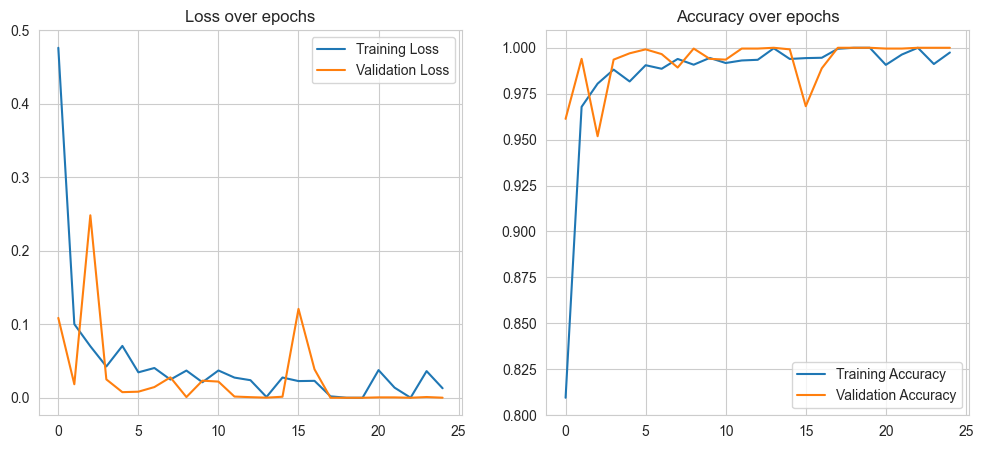

In [14]:
cnn1 = CNN1(num_classes=4).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn1.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def train_epoch(epoch_index, train_loader, model, optimizer):
    model.train()  
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch_index + 1} [train] Progress", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predictions = torch.max(outputs, 1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    avg_acc = correct_pred / total_pred
    print(f'train Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

def validate_epoch(epoch_index, val_loader, model):
    model.eval() 
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch_index + 1} [val] Progress", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predictions = torch.max(outputs, 1)
            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)

    avg_loss = running_loss / len(val_loader)
    avg_acc = correct_pred / total_pred
    print(f'val Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}')
    return avg_loss, avg_acc

# Training loop
num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
best_val_loss = float('inf')
patience = 5

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(epoch, train_loader, cnn1, optimizer)
    val_loss, val_acc = validate_epoch(epoch, val_loader, cnn1)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        trigger_times = 0
        torch.save(cnn1.state_dict(), 'model1_generalization_test.pth')
#     else:
#         trigger_times += 1
#         if trigger_times >= patience:
#             print(f"Early stopping at epoch {epoch+1}")
#             break

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Loss over epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over epochs')

plt.show()

In [15]:
# Save the best model locally (model1 - modified AlexNet)

model_save_path = '/Users/tharanidissanayake/desktop' 
os.makedirs(model_save_path, exist_ok=True) 
model_save_file = os.path.join(model_save_path, 'model1_generalization_test.pth')

torch.save(cnn1.state_dict(), model_save_file)

print(f'Model saved to {model_save_file}')

Model saved to /Users/tharanidissanayake/desktop/model1_generalization_test.pth


In [16]:
# classification report (test loader) - modified AlexNet
model1 = CNN1(num_classes=4).to(device)

model1.load_state_dict(torch.load('model1_generalization_test.pth'))

def evaluate_model(model, dataloader):
    model.eval() 
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = evaluate_model(model1, test_loader)

# Print classification report
print(classification_report(true_labels, predictions, target_names=['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented'], zero_division=0))

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       748
ModerateDemented       1.00      1.00      1.00        68
     NonDemented       1.00      1.00      1.00       778
VeryMildDemented       1.00      1.00      1.00       731

        accuracy                           1.00      2325
       macro avg       1.00      1.00      1.00      2325
    weighted avg       1.00      1.00      1.00      2325


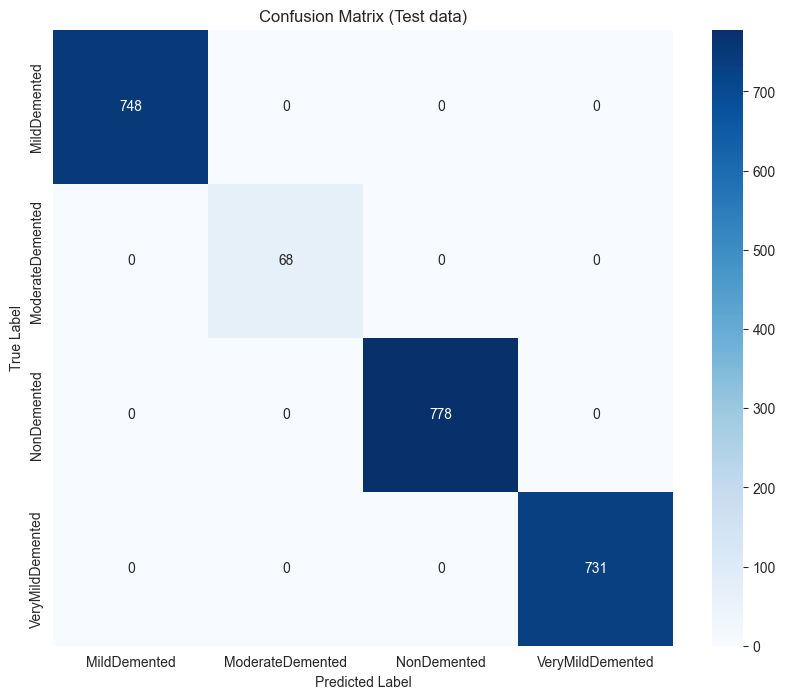

In [17]:
# Confusion Matrix on Val Loader

def get_predictions(model, dataloader):
    model.eval()  
    true_labels = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    return true_labels, predictions

# Evaluate the model
true_labels, predictions = get_predictions(model1, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Test data)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()